# Rank plotting for Exp 1 (cut to stitch and receiver only)

In [1]:
from pandas.errors import EmptyDataError
import pandas as pd
import os 
import glob 

csv_files = glob.glob(os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_rank/", "*.csv")) 
  
dfs = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['name'].index + 1 
            dfs.append(df)
    except EmptyDataError:
        continue
        
df = pd.concat(dfs, ignore_index=True)

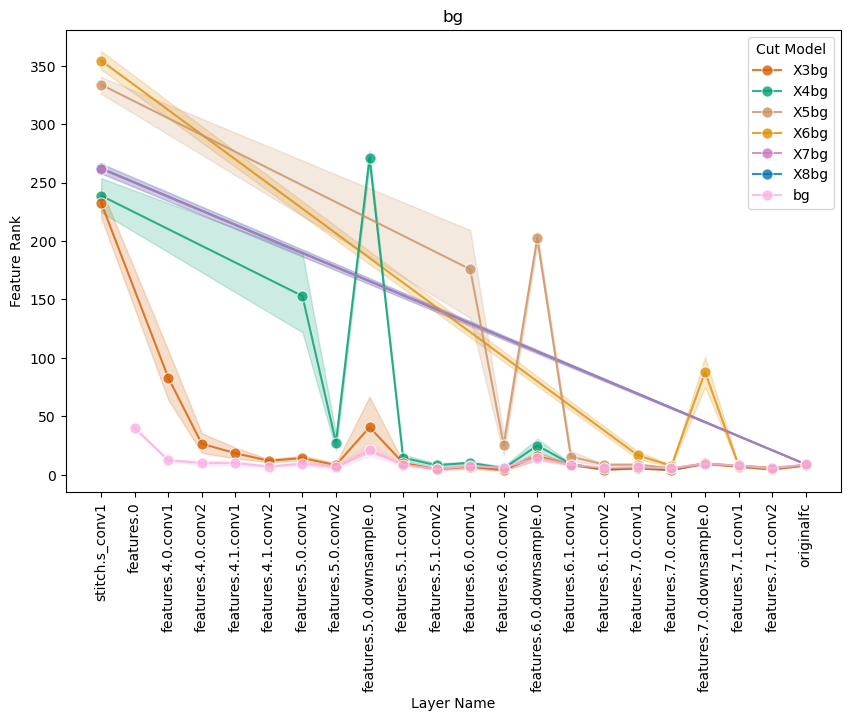

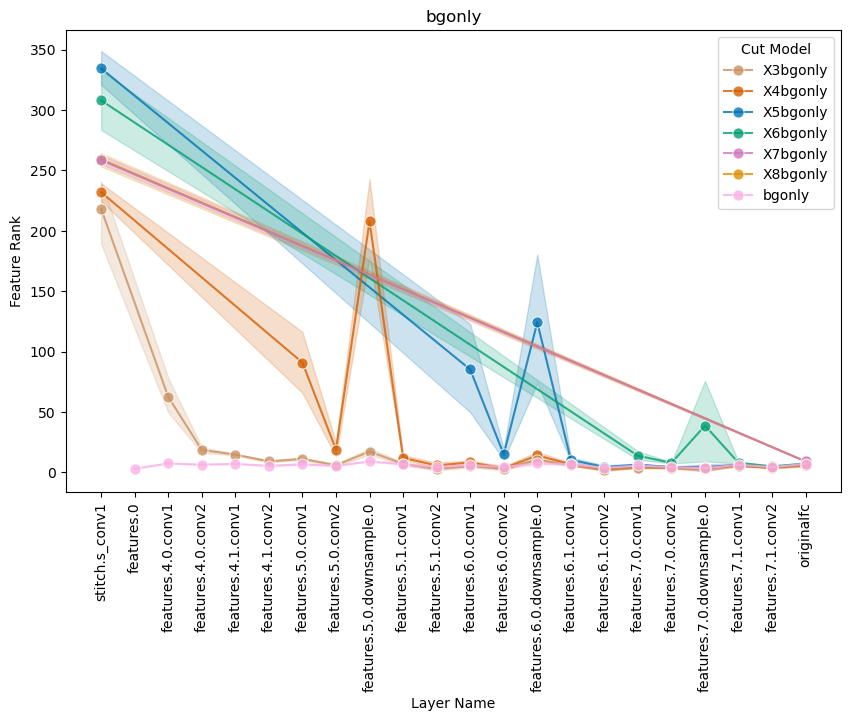

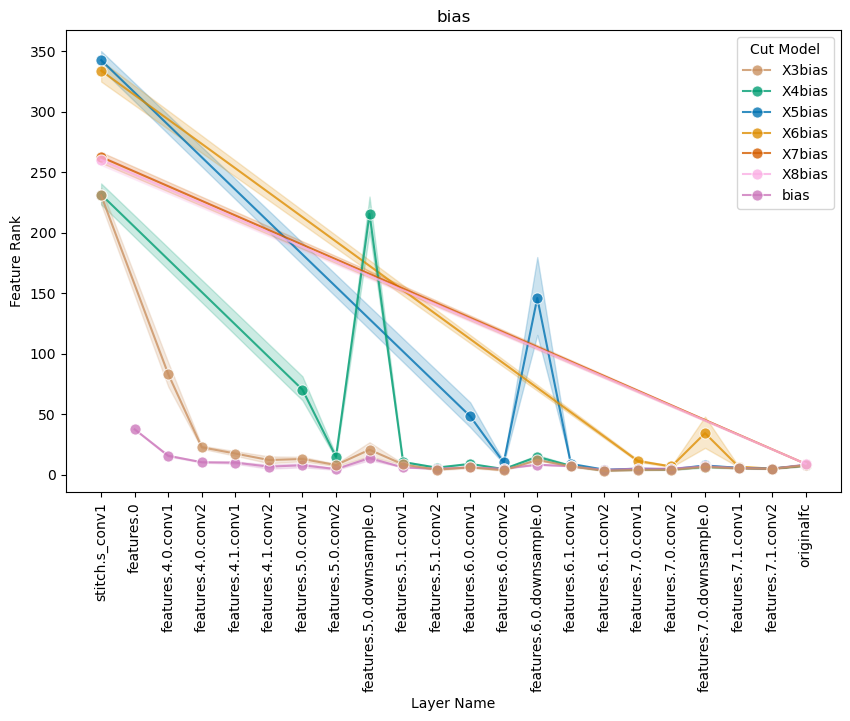

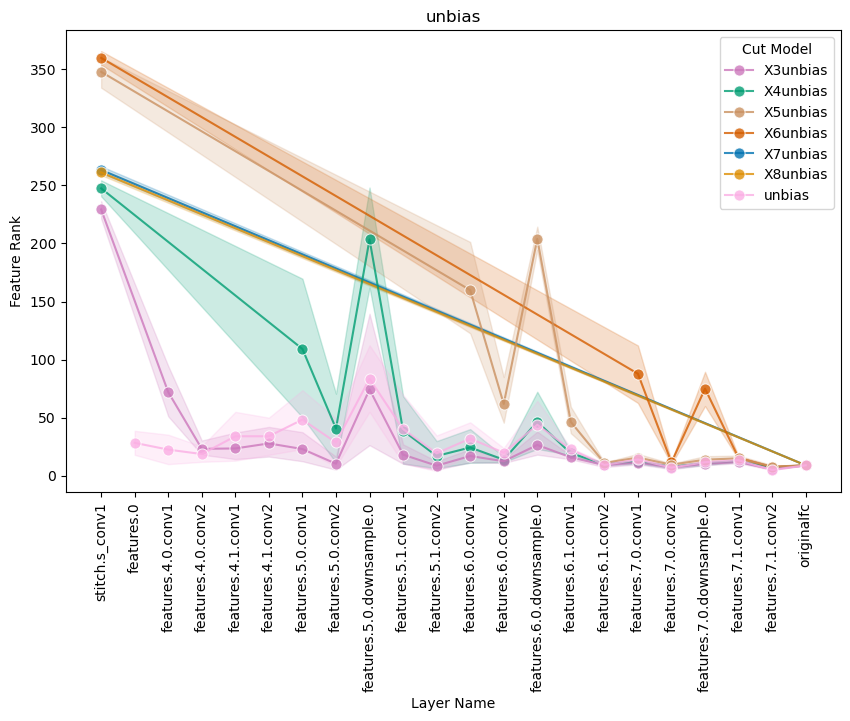

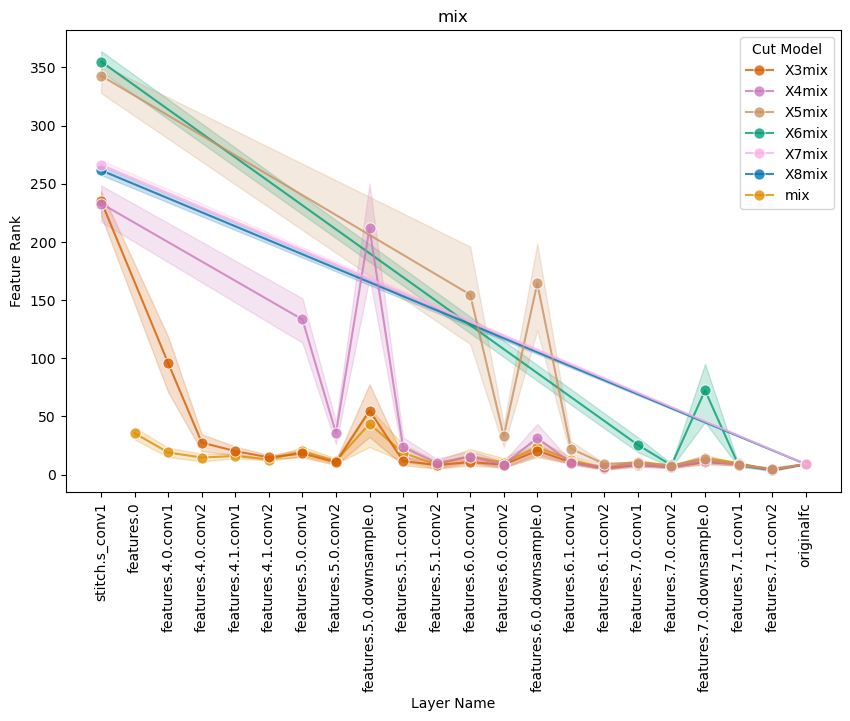

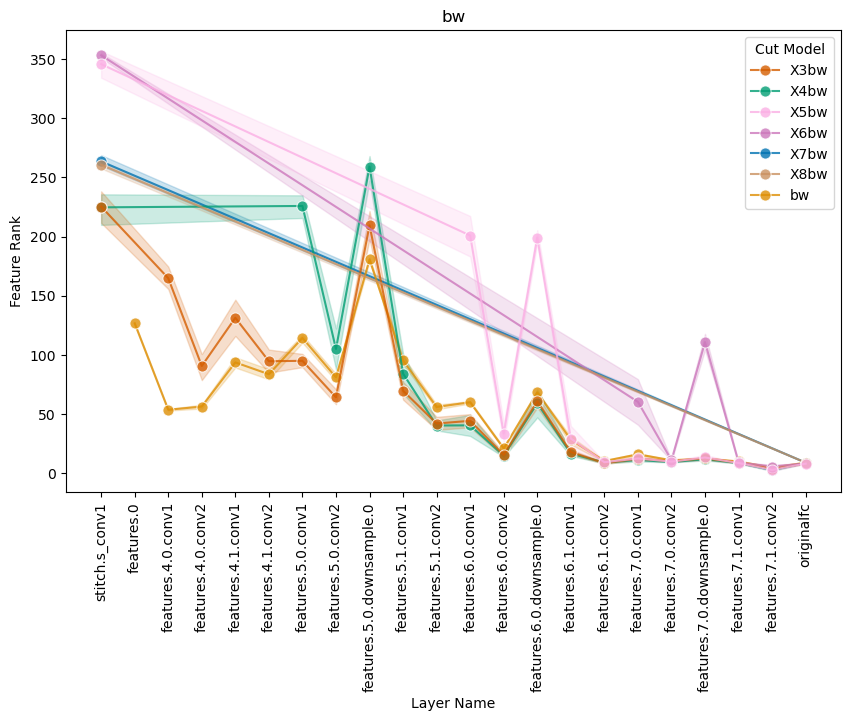

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
cat_order = ['stitch.s_conv1', 'features.0', 'features.4.0.conv1', 'features.4.0.conv2', 'features.4.1.conv1', 'features.4.1.conv2', 'features.5.0.conv1', 'features.5.0.conv2', 'features.5.0.downsample.0', 'features.5.1.conv1', 'features.5.1.conv2', 'features.6.0.conv1', 'features.6.0.conv2', 'features.6.0.downsample.0', 'features.6.1.conv1', 'features.6.1.conv2', 'features.7.0.conv1', 'features.7.0.conv2', 'features.7.0.downsample.0', 'features.7.1.conv1', 'features.7.1.conv2', 'originalfc']

graphs = {'bg': 'bg$', 'bgonly': 'bgonly', 'bias': '(?<!un)bias',  # these three may learn colours as a shortcut
          'unbias': 'unbias', 'mix': 'mix', 'bw': 'bw'}            # these three have to learn to read digits

for k, v in graphs.items(): 
    matchpattern = v
    # unsorted dataframe, but filtered to include only the data for one base model type
    df2 = df[(df['model'].str.contains(matchpattern)) ].copy()

    # Sort the model column and create a categorical type with sorted categories 
    # e.g models are X6bgonly or bgonly
    df2['name'] = pd.Categorical(df2['name'], categories=cat_order, ordered=True)

    # Create line plot
    plt.figure(figsize=(10, 6))
    line_plot = sns.lineplot(data=df2, x='name', y='features_rank', hue='model', marker='o', markersize=8, alpha=0.8, palette='colorblind')
    
    plt.title(k)
    plt.xlabel('Layer Name')
    plt.ylabel('Feature Rank')
    plt.xticks(rotation=90)
    
    handles, labels = line_plot.get_legend_handles_labels()
    sorted_labels_handles = sorted(zip(labels, handles))
    labels, handles = zip(*sorted_labels_handles)
    plt.legend(handles, labels, title='Cut Model', loc='upper right')
    plt.savefig(f"./results/{k}_rank.png", bbox_inches='tight')
    plt.show()


# Experiment 2 - Stitching

# Experiment 2 - Plot Rank After Stitch

In [4]:
from pandas.errors import EmptyDataError
import pandas as pd
import os 
import glob 

csv_files = glob.glob(os.path.join("../msc_similarity/exp2_ms_with_colorMNIST/results_rank/", "*.csv")) 
csv_files += glob.glob(os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_rank/", "*.csv")) 

dfs = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['name'].index + 1 
            dfs.append(df)
    except EmptyDataError:
        continue
        
df = pd.concat(dfs, ignore_index=True)

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)




In [5]:
send_models = {
               'bg':     '^bg(?!only)', # these three may learn colours as a shortcut
               'bgonly': '^bgonly', 
               'bias':   '^(?<!un)bias',  
               'unbias': '^unbias', # these three have to learn to read digits
               'mix':    '^mix', 
               'bw':     '^bw',
               'synth':  '^X'}

df['sender'] = 'unknown'
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k

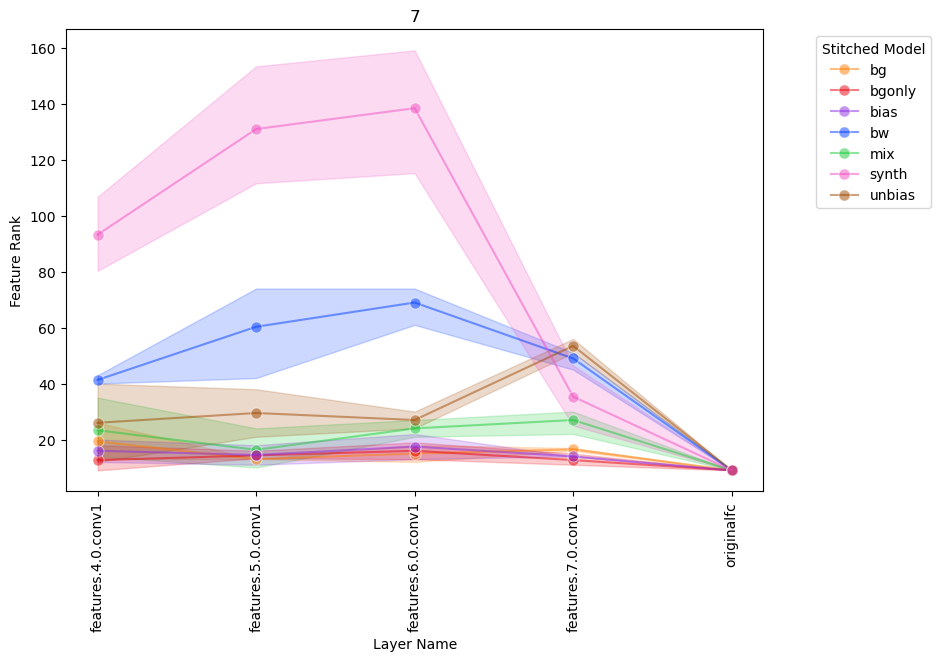

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

combined_condition = pd.Series([False] * len(df))

for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

df2 = df[combined_condition].copy() 

if True:    
    # Sort the model column and create a categorical type with sorted categories 
    # e.g models are X6bgonly or bgonly
    df2['name'] = pd.Categorical(df2['name'], categories=cat_order, ordered=True)
    # Create line plot
    plt.figure(figsize=(9,6))
    line_plot = sns.lineplot(data=df2, x='name', y='features_rank', hue='sender', marker='o', markersize=8, alpha=0.5, palette='bright')
    
    plt.title(k)
    plt.xlabel('Layer Name')
    plt.ylabel('Feature Rank')
    
    plt.xticks(rotation=90)
    
    handles, labels = line_plot.get_legend_handles_labels()
    sorted_labels_handles = sorted(zip(labels, handles))
    labels, handles = zip(*sorted_labels_handles)
    plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.savefig(f"./results_2/{k}_rank.png", bbox_inches='tight')
    plt.show()
